In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Importing only the JMA dataset first

In [2]:
# import the data

jma = pd.read_csv('C:/Users/nicol/OEAS_895/datasets/jma_nitrate.csv')
print(jma.columns)

Index(['Unnamed: 0', 'theta', 'sal', 'depth', 'nitrate', 'lon', 'lat', 'date',
       'year', 'month', 'day', 'profile', 'cruise', 'vessel', 'density'],
      dtype='object')


## This cell removes the marginal sea, Sea of Japan, for reasons perviously stated in part 1.

In [3]:
# This subset is created to ignore the marginal sea (Sea of Japan) and focusing the model on the upper 1000m since the BGC float data only covers the upper 1000m

# selects between 140 and 180°E to encapsulate most of the data desired
jma_sub_lon = jma[(jma.nitrate>=0) & (jma.lon.between(140, 180)) & (jma.lat.between(25,55))]


# selects the data south of 35°N and west of 140°W so that it ignores the data in the Sea of Japan just north of that section
jma_sub_s_lat = jma[(jma.nitrate>=0) & (jma.lon.between(130,140)) & (jma.lat.between(20,35))]


# merge two subsets
jma_sub_ocean = pd.concat([jma_sub_lon, jma_sub_s_lat])


# bin this new subset to upper 1000m
jma_sub_ocean_1000 = jma_sub_ocean[(jma_sub_ocean.depth<=1000)]


In [4]:
# split dataset into x (predictor variables) and y (variable solving for)
y = jma_sub_ocean_1000.nitrate
X_den = jma_sub_ocean_1000[['density']]
X_sal = jma_sub_ocean_1000[['sal']]
X_z = jma_sub_ocean_1000[['depth']]


# This section of the notebook is to train the MLP model on the JMA dataset for the following parameters:

* Density
* Salinity
* Depth

A rectified linear unit function 'relu' (ie. piecewise linear function) was used for non-linear activation of the MLP regressor.  This function was chosen over the others due to displaying a similar, or better fit for all parameters compared to the fit calculated for the other 3 functions (linear bottleneck, logistic sigmoid, and hyperbolic tangent).

## train & test split, scaler, and for loop for DENSITY parameter

80% of the dataset was used to train the model, and the other 20% was used to test the model

In [5]:
from sklearn.model_selection import train_test_split

#density trained
X_train_den,X_test_den,y_train_den,y_test_den = train_test_split(X_den,y,test_size=0.2,random_state=4)


from sklearn.preprocessing import StandardScaler

scaler_den = StandardScaler().fit(X_train_den)
standardized_X_den = scaler_den.transform(X_train_den)
standardized_X_test_den = scaler_den.transform(X_test_den)


# import from sklearn
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

## FOR LOOP
scores_den = {}
MSE_list_den = []

# the number and range of nodes that will be itterated in the loop
n_range = range(1, 6, 1) # always have to go one beyond the number desired (just how python works)


for n in n_range:
    print(n)
    model_den = MLPRegressor(hidden_layer_sizes=(n,), activation='relu', solver='adam',max_iter=10000)
    model_den.fit(standardized_X_den, y_train_den)
   # Make predictions using the testing set
    y_pred_den = model_den.predict(standardized_X_test_den)
    scores_den[n] = r2_score(y_test_den,y_pred_den)
    MSE_list_den.append(mean_squared_error(y_test_den,y_pred_den))
    print('r2 =', scores_den[n])
    print('MSE =', MSE_list_den)


1
r2 = 0.7621780836772751
MSE = [55.639176488877744]
2
r2 = 0.9593106708382825
MSE = [55.639176488877744, 9.519395022327107]
3
r2 = 0.9729023772221859
MSE = [55.639176488877744, 9.519395022327107, 6.339573069951629]
4
r2 = 0.973104605809483
MSE = [55.639176488877744, 9.519395022327107, 6.339573069951629, 6.292261063414533]
5
r2 = 0.9731052528341683
MSE = [55.639176488877744, 9.519395022327107, 6.339573069951629, 6.292261063414533, 6.292109689978423]


## Creates a plot of RMSE and r$^{2}$ calculated for the first 5 nodes/layer of the model.

1  0.7621780836772751
2  0.9593106708382825
3  0.9729023772221859
4  0.973104605809483
5  0.9731052528341683


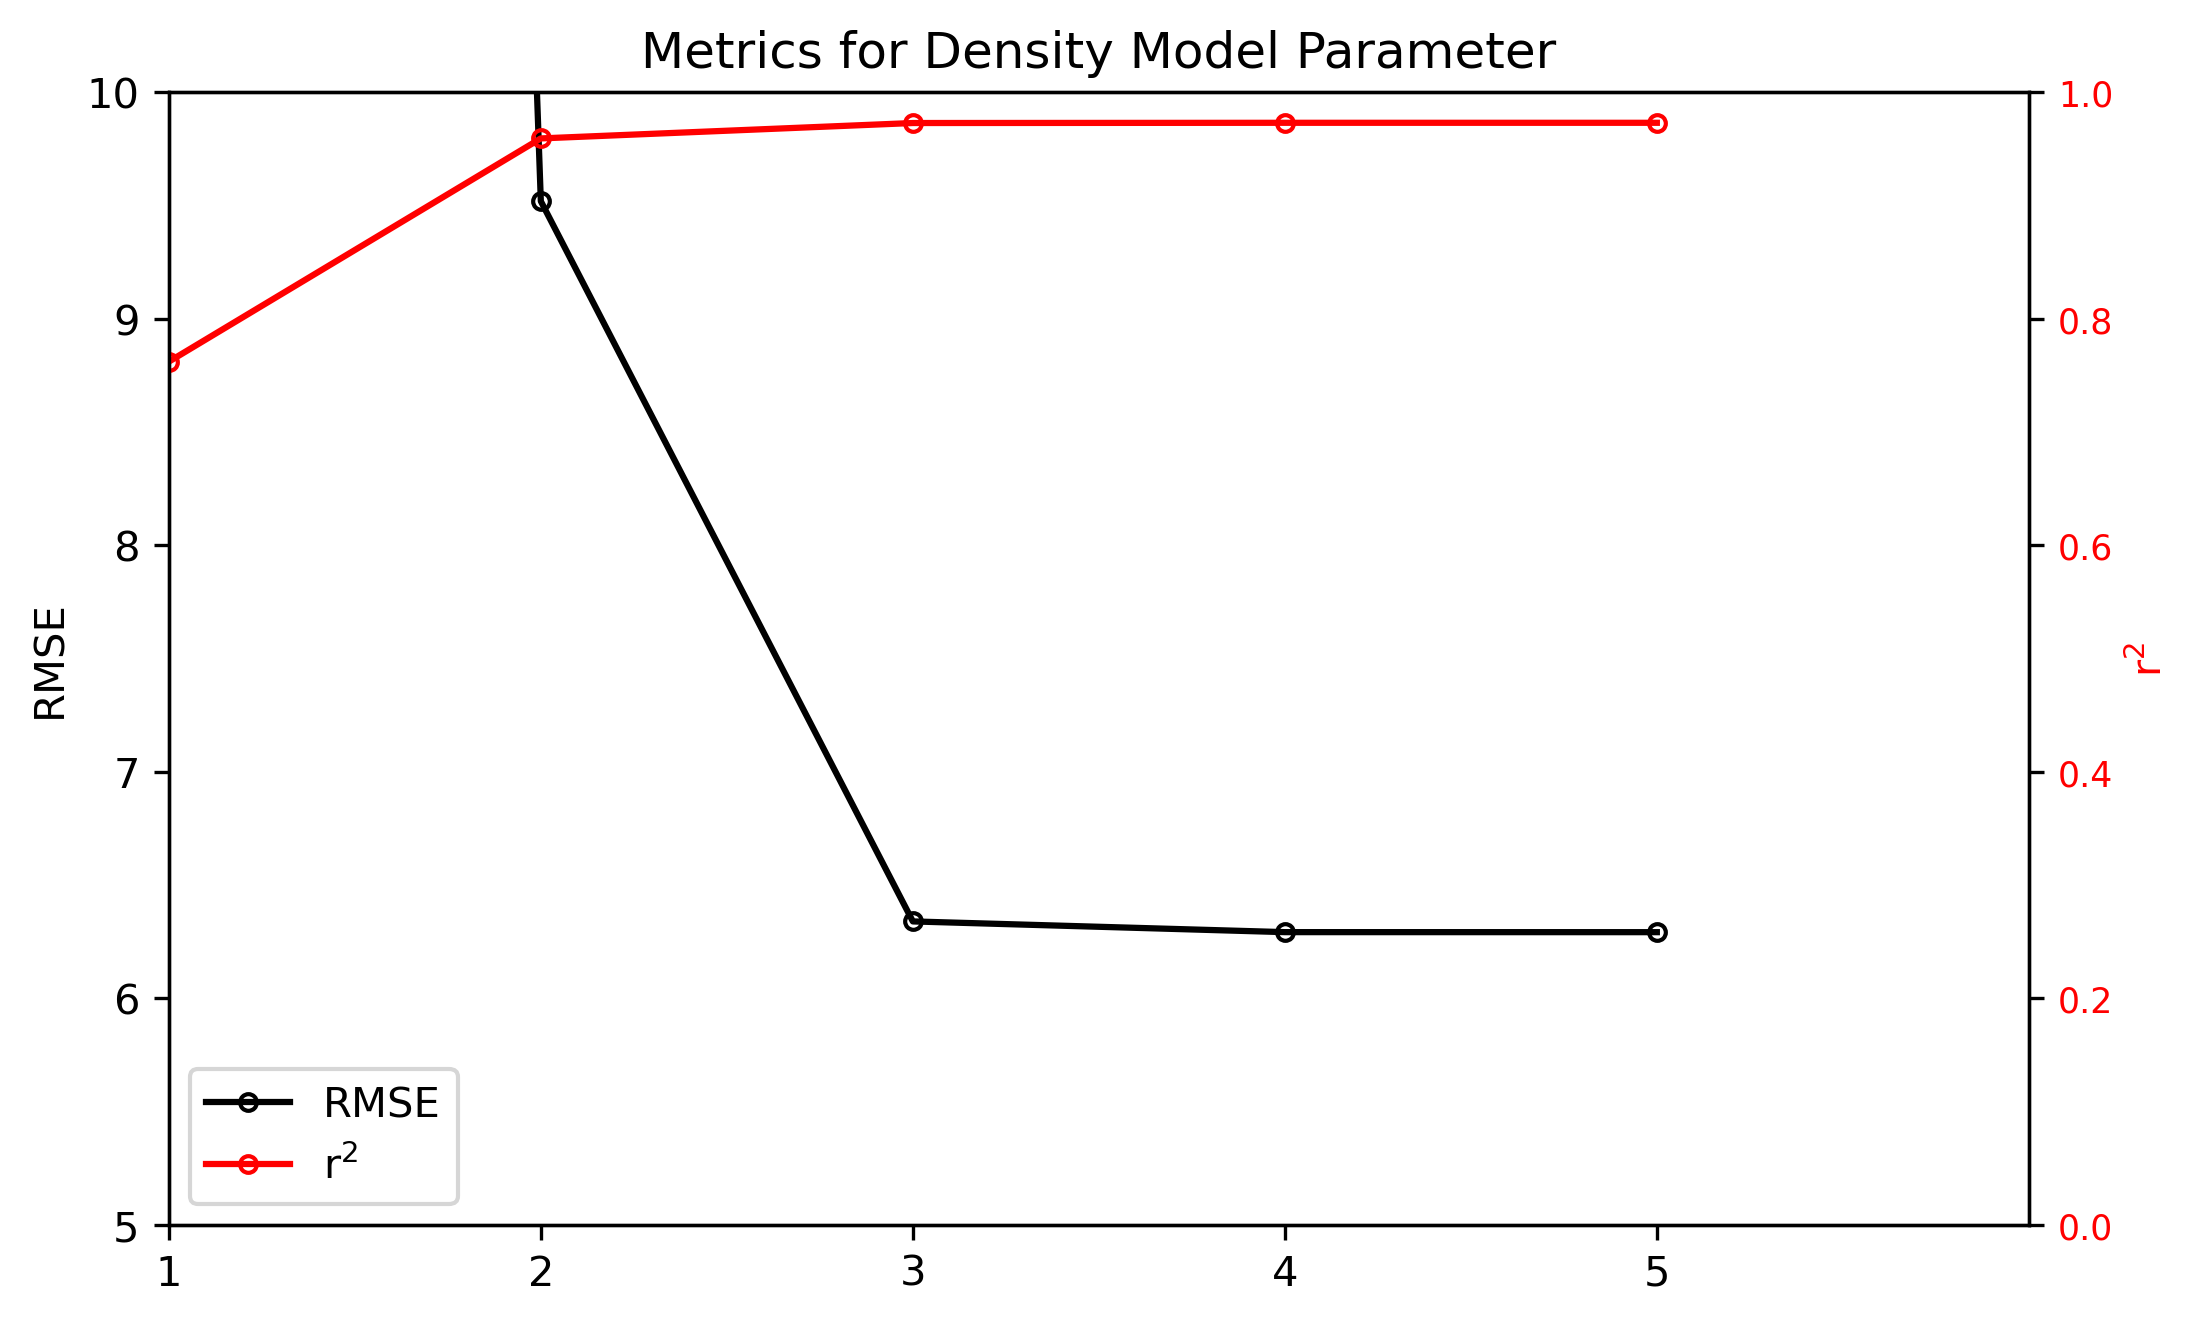

In [6]:
# because r^2 is a dictionary and not a list, separate them out and only get the r^2 values

r2_list_den = []

for a,b in scores_den.items():
    print(a,'', b)
    r2_list_den.append(b)

# where k is the node and v is the r^2 values

fig, ax1 = plt.subplots(figsize = (8,5), dpi = 300, sharex = 'all')
ax2 = ax1.twinx() # twinx creates a new axes object ax2 that shares the same x-axis with ax1\

l1 = ax1.plot(n_range, MSE_list_den, 'o-k', markersize = 4 , markerfacecolor = 'none', label = 'RMSE')
ax1.set_ylabel(r'RMSE', color = 'k')
ax1.tick_params(axis='y', labelcolor = 'black')

l2 = ax2.plot(n_range, r2_list_den, 'o-r', markersize = 4, markerfacecolor = 'none', label = 'r$^{2}$')
ax2.set_ylabel(r'r$^{2}$', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
ax2.set_xlabel('# of nodes')

x_tick_1 = [0, 5]
ax1.axis([1, 6, 5, 10])
plt.xticks(np.arange(min(x_tick_1), max(x_tick_1)+0.5, 1), fontsize = "xx-small")
x_tick_2 = [0, 1]
ax2.axis([1, 6, 0, 1.0])
plt.yticks(np.arange(min(x_tick_2), max(x_tick_2)+0.1, 0.2), fontsize = "small")

lns = l1 + l2
labs = [l.get_label() for l in lns]

plt.title('Metrics for Density Model Parameter')
ax1.legend(lns, labs, loc = 'lower left')

## Plotting the trained and tested datasets

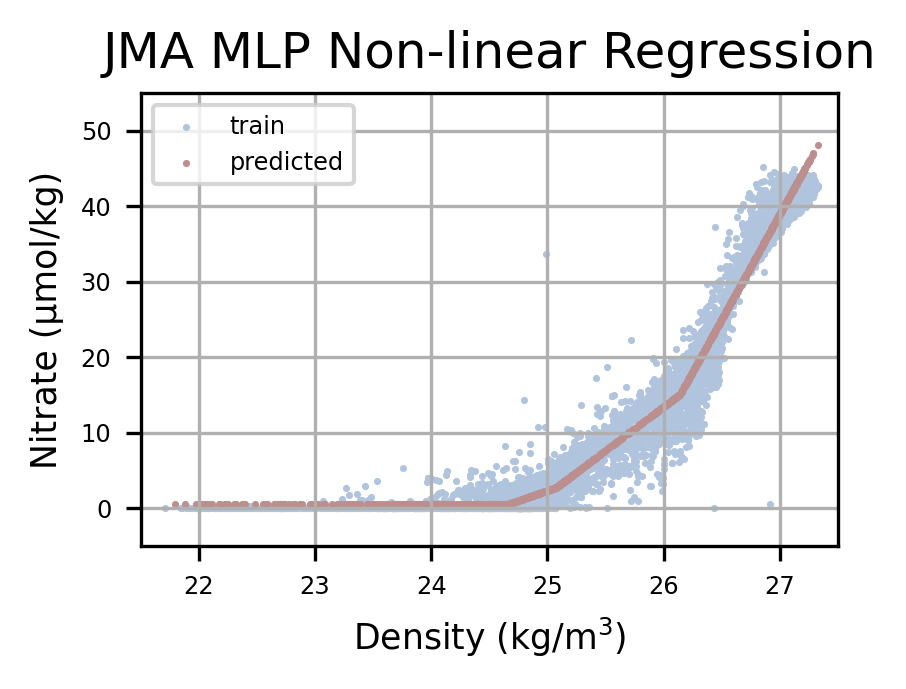

In [7]:
# plotting the results from the density rectified linear fit relationship (ie. piecewise function)

x_den_tick = [22, 27]

fig = plt.figure(figsize = (3,2), dpi = 300)
plt.scatter(X_train_den, y_train_den, c = 'lightsteelblue', label = 'train', s = 0.5)
#plt.scatter(X_test_den, y_test_den, color = 'thistle', label = 'test', s = 0.5)
plt.scatter(X_test_den, y_pred_den, color = 'rosybrown', label = 'predicted', s = 0.5)
plt.xlabel('Density (kg/m$^{3}$)', fontsize = "small")
plt.ylabel('Nitrate (µmol/kg)', fontsize = "small")
plt.axis([21.5, 27.5, -5, 55])
plt.xticks(np.arange(min(x_den_tick), max(x_den_tick)+1, 1), fontsize = "xx-small")
plt.yticks([0, 10, 20, 30, 40, 50], fontsize = "xx-small")
plt.grid()
plt.title('JMA MLP Non-linear Regression')
plt.legend(loc='upper left', fontsize = "xx-small")

## . . . . for SALINITY parameter

In [8]:
# salinity trained
X_train_sal,X_test_sal,y_train_sal,y_test_sal = train_test_split(X_sal,y,test_size=0.2,random_state=4)


scaler_sal = StandardScaler().fit(X_train_sal)
standardized_X_sal = scaler_sal.transform(X_train_sal)
standardized_X_test_sal = scaler_sal.transform(X_test_sal)


## FOR LOOP
scores_sal = {}
MSE_list_sal = []


for n in n_range:
    print('n =', n)
    model_sal = MLPRegressor(hidden_layer_sizes=(n,), activation='relu', solver='adam',max_iter=10000)
    model_sal.fit(standardized_X_sal, y_train_sal)
   # Make predictions using the testing set
    y_pred_sal = model_sal.predict(standardized_X_test_sal)
    scores_sal[n] = r2_score(y_test_sal,y_pred_sal)
    MSE_list_sal.append(mean_squared_error(y_test_sal,y_pred_sal))
    print('r2 =', scores_sal[n])
    print('MSE =', MSE_list_sal)


n = 1
r2 = 0.26136543914095833
MSE = [172.80585123472042]
n = 2
r2 = 0.5555851659087054
MSE = [172.80585123472042, 103.9722317043583]
n = 3
r2 = 0.26146987190542215
MSE = [172.80585123472042, 103.9722317043583, 172.78141886489064]
n = 4
r2 = 0.5897452414818896
MSE = [172.80585123472042, 103.9722317043583, 172.78141886489064, 95.98037585239122]
n = 5
r2 = 0.6399486909209287
MSE = [172.80585123472042, 103.9722317043583, 172.78141886489064, 95.98037585239122, 84.2351228207124]


1  0.26136543914095833
2  0.5555851659087054
3  0.26146987190542215
4  0.5897452414818896
5  0.6399486909209287


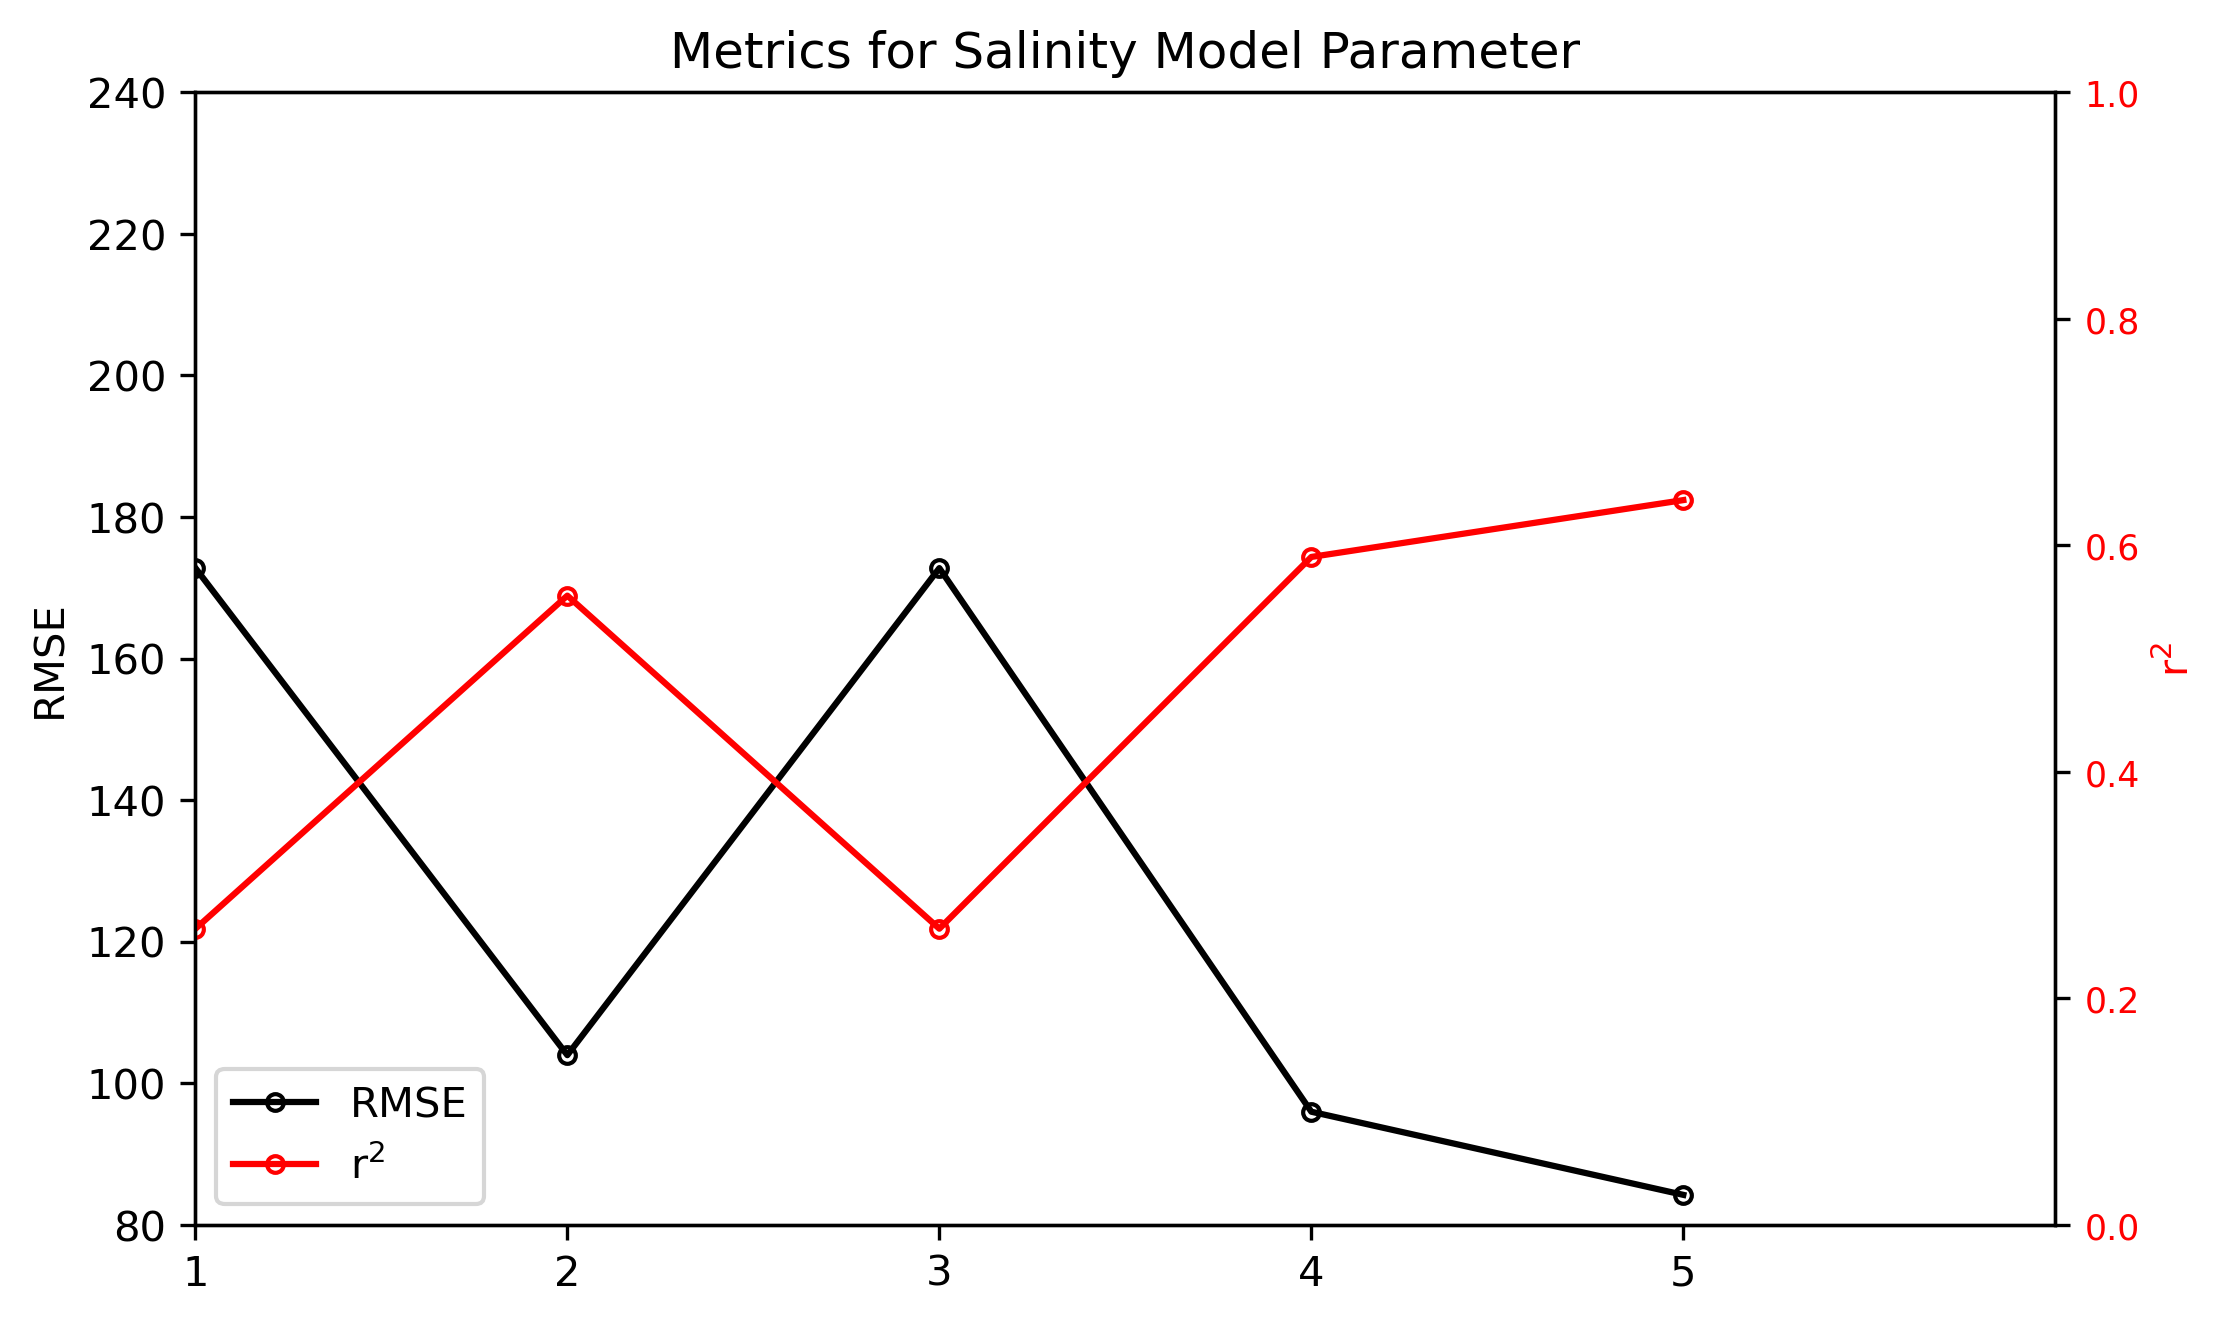

In [9]:
# because r^2 is a dictionary and not a list, separate them out and only get the r^2 values

r2_list_sal = []

for k,v in scores_sal.items():
    print(k,'', v)
    r2_list_sal.append(v)

# where k is the node and v is the r^2 values

fig, ax1 = plt.subplots(figsize = (8,5), dpi = 300, sharex = 'all')
ax2 = ax1.twinx() # twinx creates a new axes object ax2 that shares the same x-axis with ax1\

l1 = ax1.plot(n_range, MSE_list_sal, 'o-k', markersize = 4 , markerfacecolor = 'none', label = 'RMSE')
ax1.set_ylabel(r'RMSE', color = 'k')
ax1.tick_params(axis='y', labelcolor = 'black')

l2 = ax2.plot(n_range, r2_list_sal, 'o-r', markersize = 4, markerfacecolor = 'none', label = 'r$^{2}$')
ax2.set_ylabel(r'r$^{2}$', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
ax2.set_xlabel('# of nodes')

x_tick_1 = [0, 5]
ax1.axis([1, 6, 80, 240])
plt.xticks(np.arange(min(x_tick_1), max(x_tick_1)+0.5, 1), fontsize = "xx-small")
x_tick_2 = [0, 1]
ax2.axis([1, 6, 0, 1.0])
plt.yticks(np.arange(min(x_tick_2), max(x_tick_2)+0.1, 0.2), fontsize = "small")

lns = l1 + l2
labs = [l.get_label() for l in lns]

plt.title('Metrics for Salinity Model Parameter')
ax1.legend(lns, labs, loc = 'lower left')

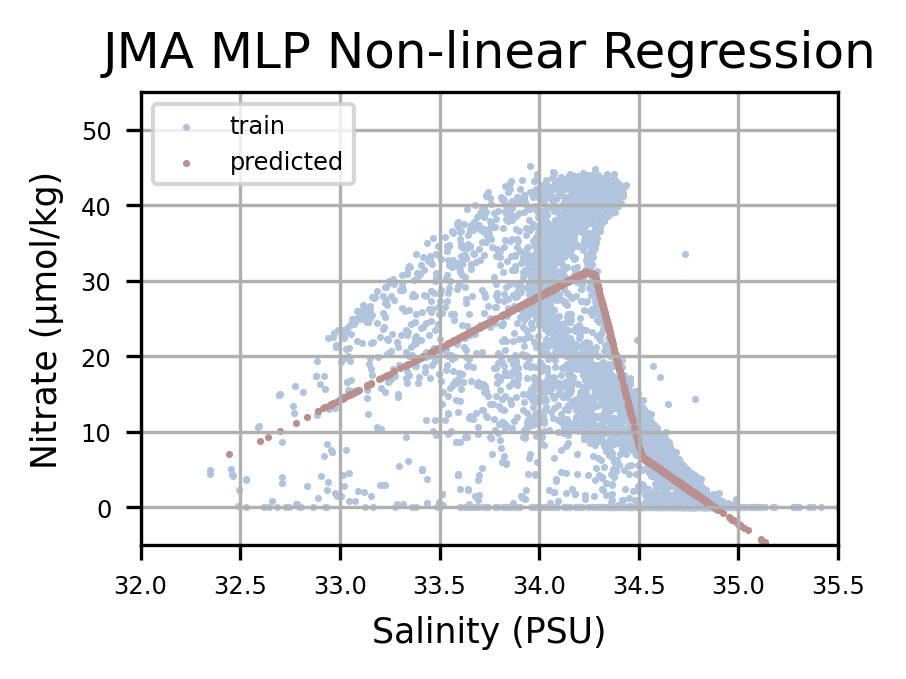

In [10]:
# plotting the results from the salinity rectified linear fit relationship (ie. piecewise function)

x_sal_tick = [32, 35]

fig = plt.figure(figsize = (3,2), dpi = 300)
plt.scatter(X_train_sal, y_train_sal, c = 'lightsteelblue', label = 'train', s = 0.5)
plt.scatter(X_test_sal, y_pred_sal, color = 'rosybrown', label = 'predicted', s = 0.5)
plt.xlabel('Salinity (PSU)', fontsize = "small")
plt.ylabel('Nitrate (µmol/kg)', fontsize = "small")
plt.axis([32, 35.5, -5, 55])
plt.xticks(np.arange(min(x_sal_tick), max(x_sal_tick)+1, 0.5), fontsize = "xx-small")
plt.yticks([0, 10, 20, 30, 40, 50], fontsize = "xx-small")
plt.grid()
plt.title('JMA MLP Non-linear Regression')
plt.legend(loc='upper left', fontsize = "xx-small")

## . . . . for DEPTH parameter

In [11]:
# depth trained
X_train_z,X_test_z,y_train_z,y_test_z = train_test_split(X_z,y,test_size=0.2,random_state=4)


scaler_z = StandardScaler().fit(X_train_z)
standardized_X_z = scaler_z.transform(X_train_z)
standardized_X_test_z = scaler_z.transform(X_test_z)


## FOR LOOP
scores_z = {}
MSE_list_z = []


for n in n_range:
    print(n)
    model_z = MLPRegressor(hidden_layer_sizes=(n,), activation='relu', solver='adam',max_iter=10000)
    model_z.fit(standardized_X_z, y_train_z)
   # Make predictions using the testing set
    y_pred_z = model_z.predict(standardized_X_test_z)
    scores_z[n] = r2_score(y_test_z,y_pred_z)
    MSE_list_z.append(mean_squared_error(y_test_z,y_pred_z))
    print('r2 =', scores_z[n])
    print('MSE =', MSE_list_z)


1
r2 = -1.344703581152018e-06
MSE = [233.95342265922636]
2
r2 = 0.7443830906845152
MSE = [233.95342265922636, 59.80237040746911]
3
r2 = 0.7444397992716859
MSE = [233.95342265922636, 59.80237040746911, 59.78910325724673]
4
r2 = 0.7442993219874188
MSE = [233.95342265922636, 59.80237040746911, 59.78910325724673, 59.82196835451307]
5
r2 = 0.7463942097471878
MSE = [233.95342265922636, 59.80237040746911, 59.78910325724673, 59.82196835451307, 59.33186285207482]


1  0.7621780836772751
2  0.9593106708382825
3  0.9729023772221859
4  0.973104605809483
5  0.9731052528341683


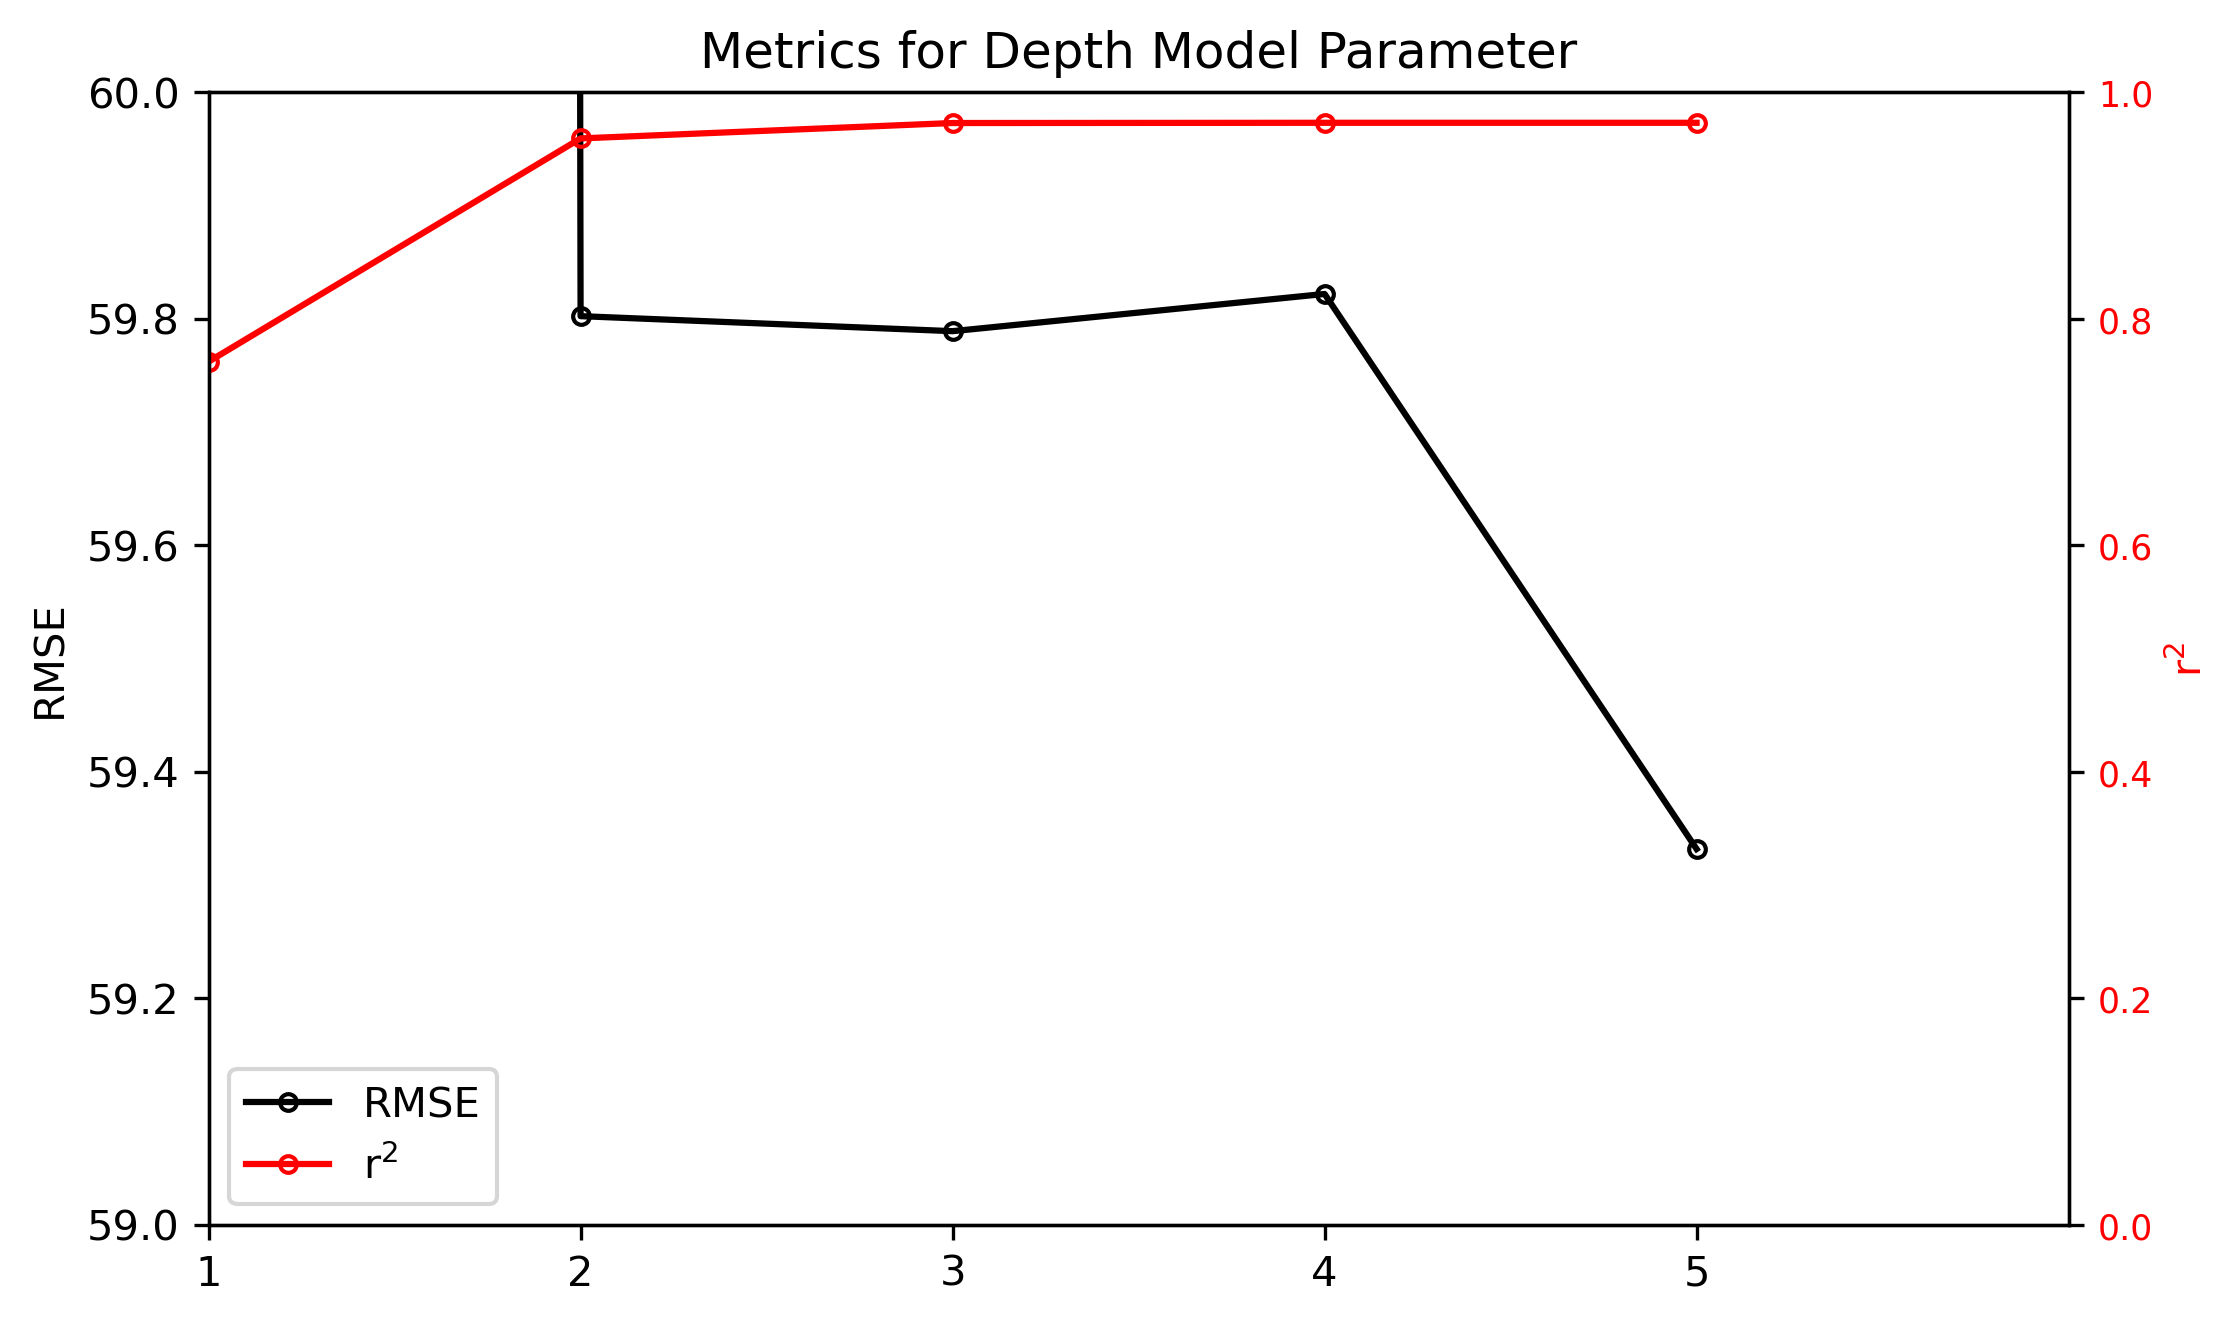

In [12]:
# because r^2 is a dictionary and not a list, separate them out and only get the r^2 values

r2_list_z = []

for c,d in scores_den.items():
    print(c,'', d)
    r2_list_z.append(d)

# where k is the node and v is the r^2 values

fig, ax1 = plt.subplots(figsize = (8,5), dpi = 300, sharex = 'all')
ax2 = ax1.twinx() # twinx creates a new axes object ax2 that shares the same x-axis with ax1\

l1 = ax1.plot(n_range, MSE_list_z, 'o-k', markersize = 4 , markerfacecolor = 'none', label = 'RMSE')
ax1.set_ylabel(r'RMSE', color = 'k')
ax1.tick_params(axis='y', labelcolor = 'black')

l2 = ax2.plot(n_range, r2_list_z, 'o-r', markersize = 4, markerfacecolor = 'none', label = 'r$^{2}$')
ax2.set_ylabel(r'r$^{2}$', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
ax2.set_xlabel('# of nodes')

x_tick_1 = [0, 5]
ax1.axis([1, 6, 59, 60])
plt.xticks(np.arange(min(x_tick_1), max(x_tick_1)+0.5, 1), fontsize = "xx-small")
x_tick_2 = [0, 1]
ax2.axis([1, 6, 0, 1.0])
plt.yticks(np.arange(min(x_tick_2), max(x_tick_2)+0.1, 0.2), fontsize = "small")

lns = l1 + l2
labs = [l.get_label() for l in lns]

plt.title('Metrics for Depth Model Parameter')
ax1.legend(lns, labs, loc = 'lower left')

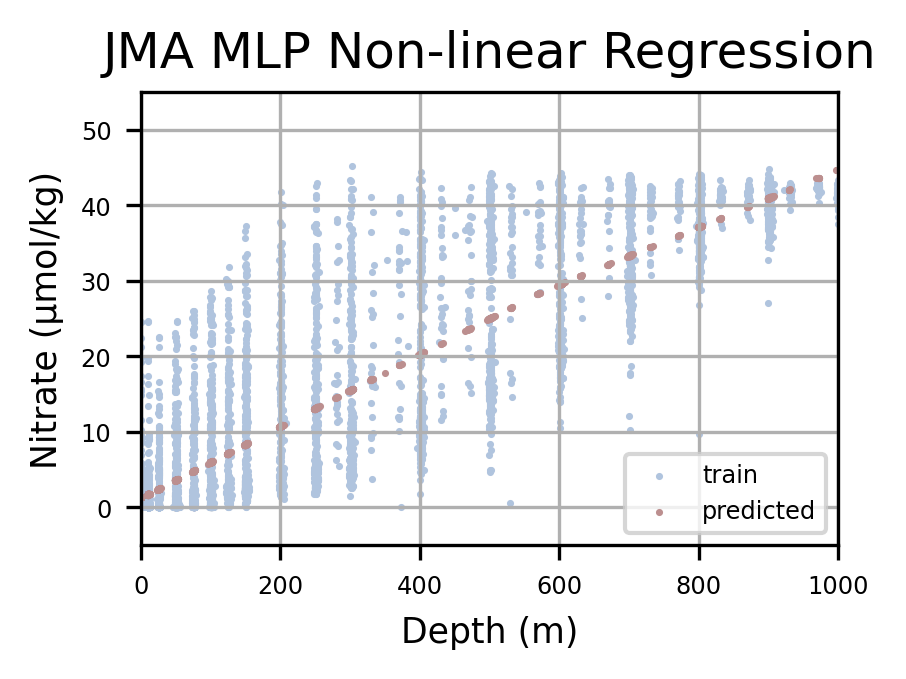

In [13]:
# plotting the results from the depth rectified linear fit relationship (ie. piecewise function)

x_depth_tick = [0, 1000]

fig = plt.figure(figsize = (3,2), dpi = 300)
plt.scatter(X_train_z, y_train_z, c = 'lightsteelblue', label = 'train', s = 0.5)
plt.scatter(X_test_z, y_pred_z, color = 'rosybrown', label = 'predicted', s = 0.5)
plt.xlabel('Depth (m)', fontsize = "small")
plt.ylabel('Nitrate (µmol/kg)', fontsize = "small")
plt.axis([32, 35.5, -5, 55])
plt.xticks(np.arange(min(x_depth_tick), max(x_depth_tick)+1, 200), fontsize = "xx-small")
plt.yticks([0, 10, 20, 30, 40, 50], fontsize = "xx-small")
plt.grid()
plt.title('JMA MLP Non-linear Regression')
plt.legend(loc='lower right', fontsize = "xx-small")

# Importing the BGC Argo dataset w/o nitrate data

In [14]:
# import the data

bgc = pd.read_csv('C:/Users/nicol/OEAS_895/datasets/kuro_BGCargo_noNO3 - modified.csv')
print(bgc.columns)

# no need to create a subset since this dataset is only in the upper 1000m and has no nitrate data (in this csv at least)


Index(['Date/GMT', 'Year', 'Month', 'Day', 'Days since 1/1/1900', 'DEPTH[M]',
       'PRESSURE[DBAR]', 'NA', 'SALINITY[PSS]', 'TEMPERATURE[C]',
       'SIGMATHETA[KG/M3]', 'OXYGEN[uMOL/KG]', 'OXYGENSAT', 'LON', 'LAT'],
      dtype='object')


In [15]:
# split dataset into x (predictor variables) and y (variable solving for)
#y = jma_sub_ocean_1000.nitrate
X_bgc = bgc[['SIGMATHETA[KG/M3]', 'DEPTH[M]','SALINITY[PSS]']]

X_bgc_den = bgc[['SIGMATHETA[KG/M3]']]
X_bgc_z = abs(bgc[['DEPTH[M]']])
X_bgc_sal = bgc[['SALINITY[PSS]']]


# Beginning to fit the JMA model to the density parameter

In [16]:
from sklearn.preprocessing import StandardScaler

scaler_bgc_den = StandardScaler().fit(X_bgc_den)
standardized_X_bgc_den = scaler_bgc_den.transform(X_bgc_den)



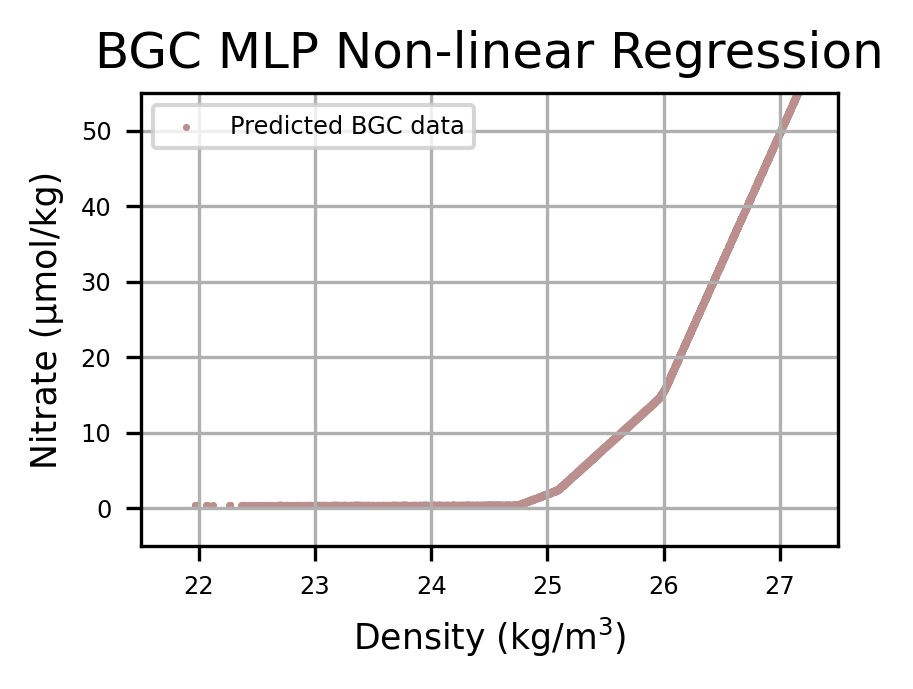

In [27]:
# plotting the results from the density rectified linear fit relationship (ie. piecewise function)

# n = 5 nodes because had the highest r^2 and lowest RMSE
model_den_bgc = MLPRegressor(hidden_layer_sizes=(5,), activation='relu', solver='adam',max_iter=10000)
model_den_bgc.fit(standardized_X_den, y_train_den)

# Make predictions using the ARGO BGC set
y_pred_bgc_den = model_den_bgc.predict(standardized_X_bgc_den)

fig = plt.figure(figsize = (3,2), dpi = 300)
plt.scatter(X_bgc_den, y_pred_bgc_den, color = 'rosybrown', label = 'Predicted BGC data', s = 0.5)
plt.xlabel('Density (kg/m$^{3}$)', fontsize = "small")
plt.ylabel('Nitrate (µmol/kg)', fontsize = "small")
plt.axis([21.5, 27.5, -5, 55])
plt.xticks(np.arange(min(x_den_tick), max(x_den_tick)+1, 1), fontsize = "xx-small")
plt.yticks([0, 10, 20, 30, 40, 50], fontsize = "xx-small")
plt.grid()
plt.title('BGC MLP Non-linear Regression')
plt.legend(loc='upper left', fontsize = "xx-small")

# Beginning to fit the JMA model to the salinity parameter

In [28]:

scaler_bgc_sal = StandardScaler().fit(X_bgc_sal)
standardized_X_bgc_sal = scaler_bgc_sal.transform(X_bgc_sal)


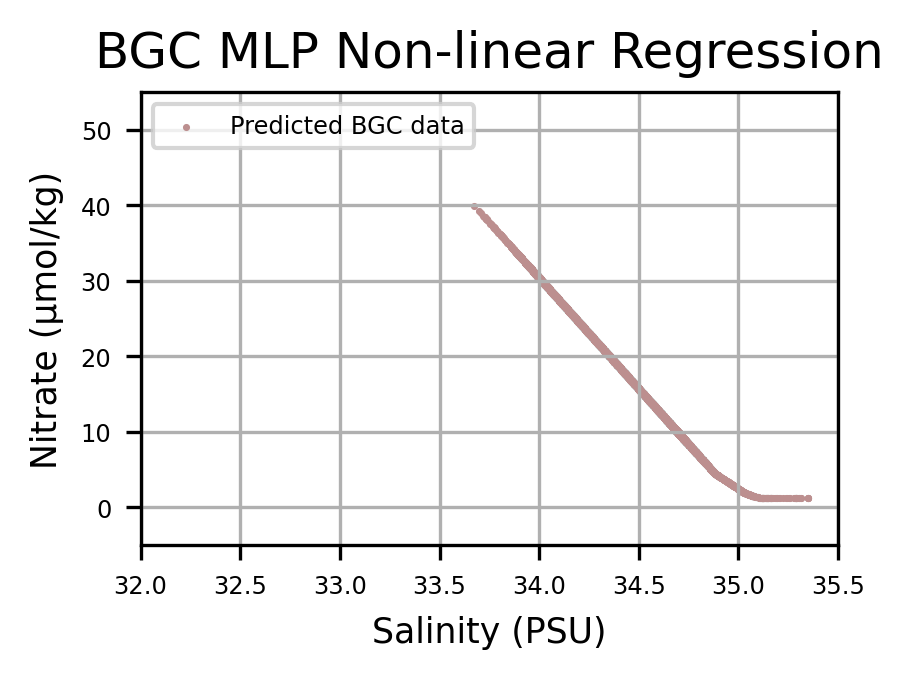

In [29]:
# plotting the results from the salinity rectified linear fit relationship (ie. piecewise function)

# n = 5 nodes because had the highest r^2 and lowest RMSE
model_sal_bgc = MLPRegressor(hidden_layer_sizes=(5,), activation='relu', solver='adam',max_iter=10000)
model_sal_bgc.fit(standardized_X_sal, y_train_sal)

# Make predictions using the ARGO BGC set
y_pred_bgc_sal = model_sal_bgc.predict(standardized_X_bgc_sal)


fig = plt.figure(figsize = (3,2), dpi = 300)
plt.scatter(X_bgc_sal, y_pred_bgc_sal, color = 'rosybrown', label = 'Predicted BGC data', s = 0.5)
plt.xlabel('Salinity (PSU)', fontsize = "small")
plt.ylabel('Nitrate (µmol/kg)', fontsize = "small")
plt.axis([32, 35.5, -5, 55])
plt.xticks(np.arange(min(x_sal_tick), max(x_sal_tick)+1, 0.5), fontsize = "xx-small")
plt.yticks([0, 10, 20, 30, 40, 50], fontsize = "xx-small")
plt.grid()
plt.title('BGC MLP Non-linear Regression')
plt.legend(loc='upper left', fontsize = "xx-small")

# Beginning to fit the JMA model to the depth parameter

In [30]:
scaler_bgc_z = StandardScaler().fit(X_bgc_z)
standardized_X_bgc_z = scaler_bgc_z.transform(X_bgc_z)

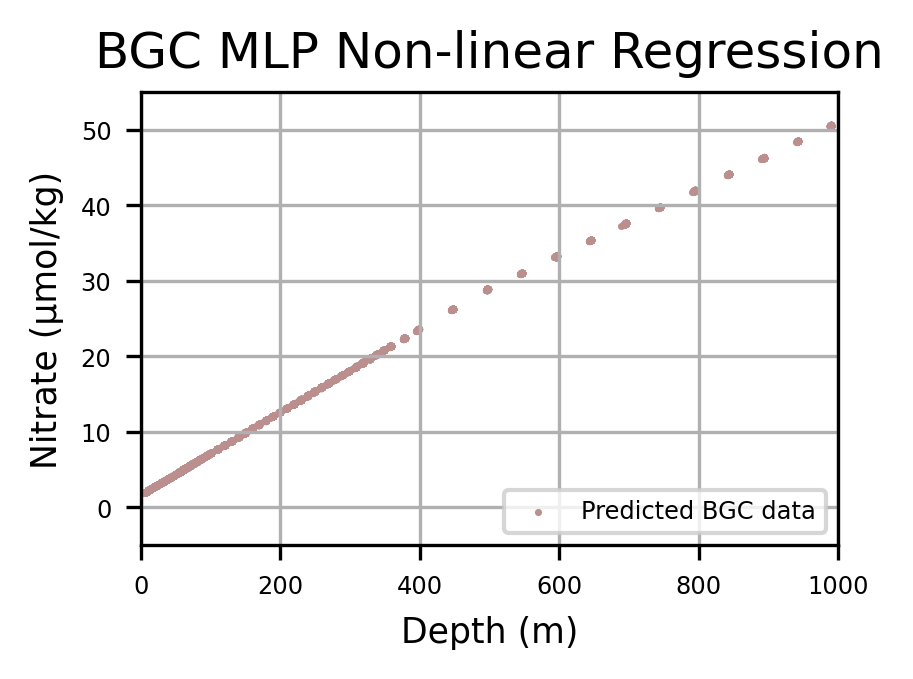

In [31]:
# plotting the results from the depth rectified linear fit relationship (ie. piecewise function)

# n = 5 nodes because had the highest r^2 and lowest RMSE
model_z_bgc = MLPRegressor(hidden_layer_sizes=(5,), activation='relu', solver='adam',max_iter=10000)
model_z_bgc.fit(standardized_X_z, y_train_z)


# Make predictions using the testing set
y_pred_bgc_z = model_z.predict(standardized_X_bgc_z)

fig = plt.figure(figsize = (3,2), dpi = 300)
plt.scatter(X_bgc_z, y_pred_bgc_z, color = 'rosybrown', label = 'Predicted BGC data', s = 0.5)
plt.xlabel('Depth (m)', fontsize = "small")
plt.ylabel('Nitrate (µmol/kg)', fontsize = "small")
plt.axis([32, 35.5, -5, 55])
plt.xticks(np.arange(min(x_depth_tick), max(x_depth_tick)+1, 200), fontsize = "xx-small")
plt.yticks([0, 10, 20, 30, 40, 50], fontsize = "xx-small")
plt.grid()
plt.title('BGC MLP Non-linear Regression')
plt.legend(loc='lower right', fontsize = "xx-small")

# Importing the BGC Argo dataset w/ nitrate data

In [32]:
# Load the BGC dataset that DOES HAVE nitrate data

bgc_NO3 = pd.read_csv('C:/Users/nicol/OEAS_895/datasets/kuro_BGCargo_NO3.csv')
print(bgc_NO3.columns)

Index(['Date/GMT', 'Days since 1/1/1900', 'NITRATE[uMOL/KG]', 'DEPTH[M]',
       'PRESSURE[DBAR]', 'NA', 'SALINITY[PSS]', 'TEMPERATURE[C]',
       'SIGMATHETA[KG/M3]', 'OXYGEN[uMOL/KG]', 'OXYGENSAT', 'LON', 'LAT'],
      dtype='object')


In [33]:
# split dataset 
y_bgc_NO3 = bgc_NO3[['NITRATE[uMOL/KG]']]
X_bgc_NO3 = bgc_NO3[['SIGMATHETA[KG/M3]', 'DEPTH[M]','SALINITY[PSS]']]


# Validating the modeled nitrate data with the actual

r2 = 0.736224544666767
MSE = 46.00426431827193


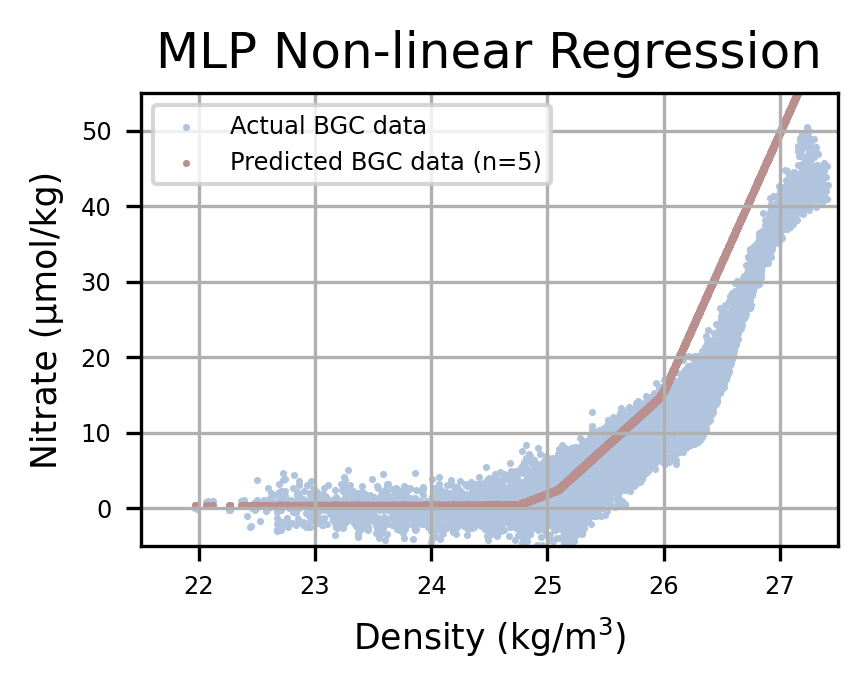

In [34]:
fig = plt.figure(figsize = (3,2), dpi = 300)

plt.scatter(X_bgc_NO3['SIGMATHETA[KG/M3]'], y_bgc_NO3, color = 'lightsteelblue', label = 'Actual BGC data', s = 0.5)
plt.scatter(X_bgc['SIGMATHETA[KG/M3]'], y_pred_bgc_den, color = 'rosybrown', label = 'Predicted BGC data (n=5)', s = 0.5)
plt.xlabel('Density (kg/m$^{3}$)', fontsize = "small")
plt.ylabel('Nitrate (µmol/kg)', fontsize = "small")
plt.axis([21.5, 27.5, -5, 55])
plt.xticks(np.arange(min(x_den_tick), max(x_den_tick)+1, 1), fontsize = "xx-small")
plt.yticks([0, 10, 20, 30, 40, 50], fontsize = "xx-small")
plt.grid()
plt.title('MLP Non-linear Regression')
plt.legend(loc='upper left', fontsize = "xx-small")

print('r2 =', r2_score(y_bgc_NO3,y_pred_bgc_den))
print('MSE =', mean_squared_error(y_bgc_NO3,y_pred_bgc_den))

r2 = 0.42792012773934984
MSE = 99.77468760842045


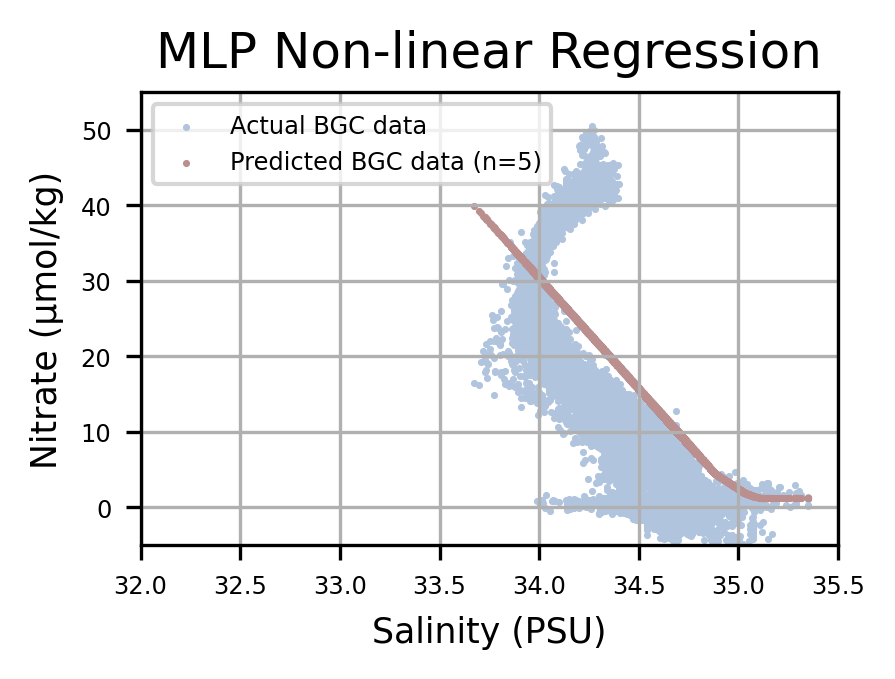

In [35]:
fig = plt.figure(figsize = (3,2), dpi = 300)

plt.scatter(X_bgc_NO3['SALINITY[PSS]'], y_bgc_NO3, color = 'lightsteelblue', label = 'Actual BGC data', s = 0.5)
plt.scatter(X_bgc['SALINITY[PSS]'], y_pred_bgc_sal, color = 'rosybrown', label = 'Predicted BGC data (n=5)', s = 0.5)
plt.xlabel('Salinity (PSU)', fontsize = "small")
plt.ylabel('Nitrate (µmol/kg)', fontsize = "small")
plt.axis([32, 35.5, -5, 55])
plt.xticks(np.arange(min(x_sal_tick), max(x_sal_tick)+1, 0.5), fontsize = "xx-small")
plt.yticks([0, 10, 20, 30, 40, 50], fontsize = "xx-small")
plt.grid()
plt.title('MLP Non-linear Regression')
plt.legend(loc='upper left', fontsize = "xx-small")

print('r2 =', r2_score(y_bgc_NO3,y_pred_bgc_sal))
print('MSE =', mean_squared_error(y_bgc_NO3,y_pred_bgc_sal))

r2 = 0.7500145715916748
MSE = 43.59918821743419


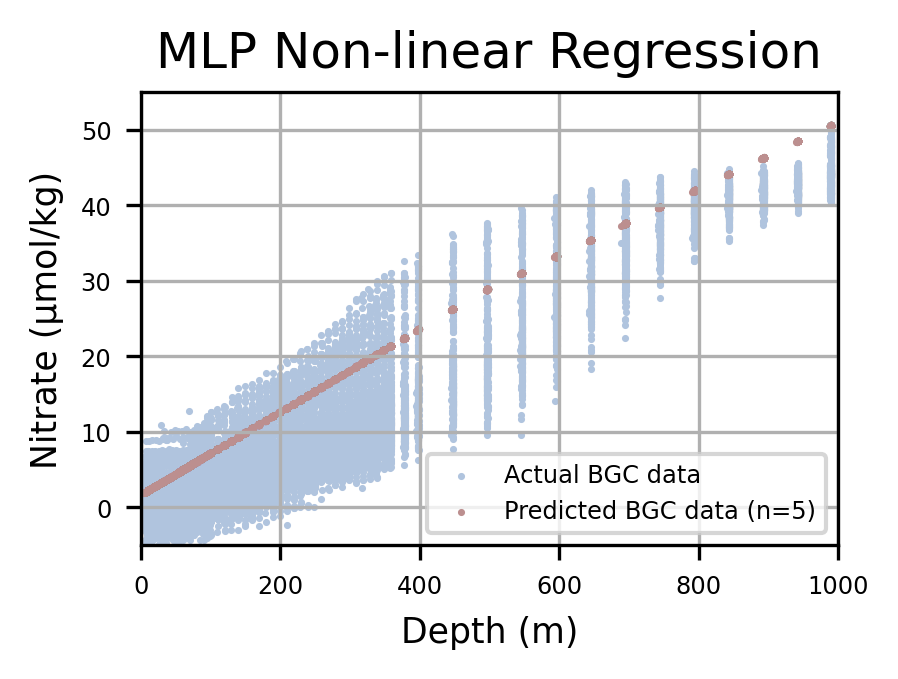

In [36]:
fig = plt.figure(figsize = (3,2), dpi = 300)

plt.scatter(abs(X_bgc_NO3['DEPTH[M]']), y_bgc_NO3, color = 'lightsteelblue', label = 'Actual BGC data', s = 0.5)
plt.scatter(abs(X_bgc['DEPTH[M]']), y_pred_bgc_z, color = 'rosybrown', label = 'Predicted BGC data (n=5)', s = 0.5)
plt.xlabel('Depth (m)', fontsize = "small")
plt.ylabel('Nitrate (µmol/kg)', fontsize = "small")
plt.axis([32, 35.5, -5, 55])
plt.xticks(np.arange(min(x_depth_tick), max(x_depth_tick)+1, 200), fontsize = "xx-small")
plt.yticks([0, 10, 20, 30, 40, 50], fontsize = "xx-small")
plt.grid()
plt.title('MLP Non-linear Regression')
plt.legend(loc='lower right', fontsize = "xx-small")

print('r2 =', r2_score(y_bgc_NO3,y_pred_bgc_z))
print('MSE =', mean_squared_error(y_bgc_NO3,y_pred_bgc_z))

# Comparing the r2 and RMSE for each of the predictor variables used to train and test the JMA model used to predict nitrate concentrations

Density:  

    r2 = 0.9731052528341683
    RMSE = 6.292109689978423 

Salinity: 

    r2 = 0.6399486909209287
    RMSE = 84.2351228207124

Depth: 

    r2 = 0.7463942097471878
    RMSE = 59.33186285207482
    
# Comparing the r2 and RMSE for each of the predictor variables used to predict nitrate concentrations for the BGC data

Density:  

    r2 = 0.736224544666767
    RMSE = 46.00426431827193 

Salinity: 

    r2 = 0.42792012773934984
    RMSE = 99.77468760842045

Depth: 

    r2 = 0.7500145715916748
    RMSE = 43.59918821743419
    


Looking first at the model trained on the JMA dataset, using density as the predictor variable gave the best fit where 97.3% of the variation in the nitrate concentrations can be predicted from density with an RMSE of ~6.3.  Whereas using depth as the predictor variable gave the next best fit, followed by salinity. 

Applying that trained model to the BGC dataset gave comparable reasonable fits when using density and depth as the predictor variables accurately approximate the real nitrate concentrations 73.6-75% of the time for those independent variables.  Similar to the trained model, the salinity gave the worst fit, only accurately appriximating the nitrate concentrations 42.8% of the time. 

## Does your model perform consistently well, or are there any noticeable outliers?

The density trained model performs pretty well up until the higher density values (greater than 26 kg/m^3) where the model then begins to over approximate the nitrate concentrations. 

The salinity trained model does not preform that well and this is likely primarily due to the shift in salinity range.  The BGC dataset has a much narrower region of salinity values reported. The JMA dataset covered a much larger geographical region and had alot more coastal influence (and thus lower salinity values reported in addition to those higher salinity values found in the more open ocean).  The model was trained on a dataset that had a much wider range of salinity values, whereas the BGC dataset it was applied to was much more narrow and thus, less weight was probably placed on those higher salinity ranges when applied to the BGC dataset. For this reason, the salinity trained model mostly under approximate the nitrate concentrations.

The depth trained model preforms just as well on the BGC dataset as when trained and tested on the JMA dataset. In the upper 800m of the water column, the model neither over or under approximates the nitrate concentrations until you get below 800m where it will likely over approximate the nitrate concentrations with increasing depth. 

## Ideas for future attempts

In the future, I would consider further slicing the data to remove those in the JMA dataset that have more coastal influence due to proximity to land.  This may result in a JMA training set that better matches those from what was collected in the open ocean BGC argo float dataset. 

Another thing noticed in part 1 is that the actual nitrate concentrations from the BGC dataset have negative values in the profiles which makes me believe that the values reported from the float sensor could benefit from a recent calibration. 